In [1]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

2021-10-12 13:18:14.492898: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
dataset_name = "maps"

In [3]:
_URL = f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz'

path_to_zip = tf.keras.utils.get_file(
    fname=f"{dataset_name}.tar.gz",
    origin=_URL,
    extract=True)

path_to_zip  = pathlib.Path(path_to_zip)

PATH = path_to_zip.parent/dataset_name

250249216/250242400 [==============================] - 121s 0us/step


In [4]:
list(PATH.parent.iterdir())

[PosixPath('/root/.keras/datasets/maps.tar.gz'),
 PosixPath('/root/.keras/datasets/maps')]

In [5]:
sample_image = tf.io.read_file(str(PATH / 'train/1.jpg'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

(600, 1200, 3)


2021-10-12 13:20:24.663679: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-12 13:20:24.666407: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-12 13:20:24.704558: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-12 13:20:24.705171: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-12 13:20:24.705250: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-12 13:20:24.736085: I tensorflow/stream_executor/platform/def

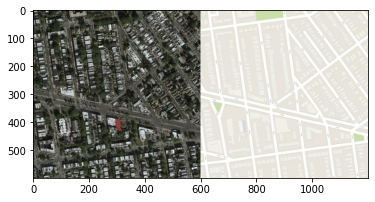

In [6]:
plt.figure()
plt.imshow(sample_image)

In [7]:
def load(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # - one with a real building facade image
  # - one with an architecture label image 
  w = tf.shape(image)[1]
  w = w // 2
  input_image = image[:, w:, :]
  real_image = image[:, :w, :]

  # Convert both images to float32 tensors
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

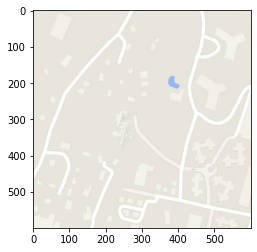

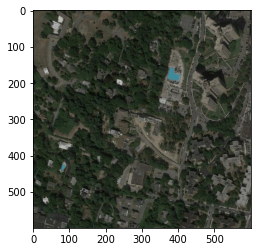

In [8]:
inp, re = load(str(PATH / 'train/100.jpg'))
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

In [9]:
PATH

PosixPath('/root/.keras/datasets/maps')

In [10]:
!cp -r /root/.keras/datasets/maps /content/

In [11]:
import os

for root, dirs, files in os.walk("maps"):
    print(f"There are {len(dirs)} directories and {len(files)} files in {root}")

In [12]:
# The facade training set consist of 400 images
BUFFER_SIZE = 2000
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 32
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [13]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [14]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [15]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [16]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

2021-10-12 13:20:41.094899: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-12 13:20:41.108581: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000165000 Hz


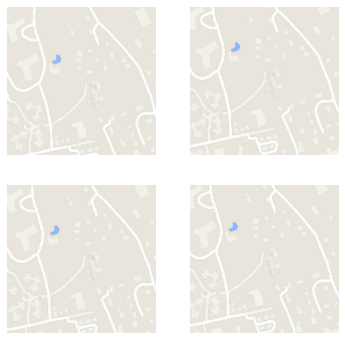

In [17]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()

In [18]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [19]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [20]:
train_dataset = tf.data.Dataset.list_files(str(PATH / 'train/*.jpg'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [21]:
try:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'test/*.jpg'))
except tf.errors.InvalidArgumentError:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'val/*.jpg'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [22]:
OUTPUT_CHANNELS = 3

In [23]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [24]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

2021-10-12 13:20:49.486495: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2021-10-12 13:20:54.672536: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11


(1, 300, 300, 3)


2021-10-12 13:20:55.401360: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


In [25]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [26]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 600, 600, 3)


In [27]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

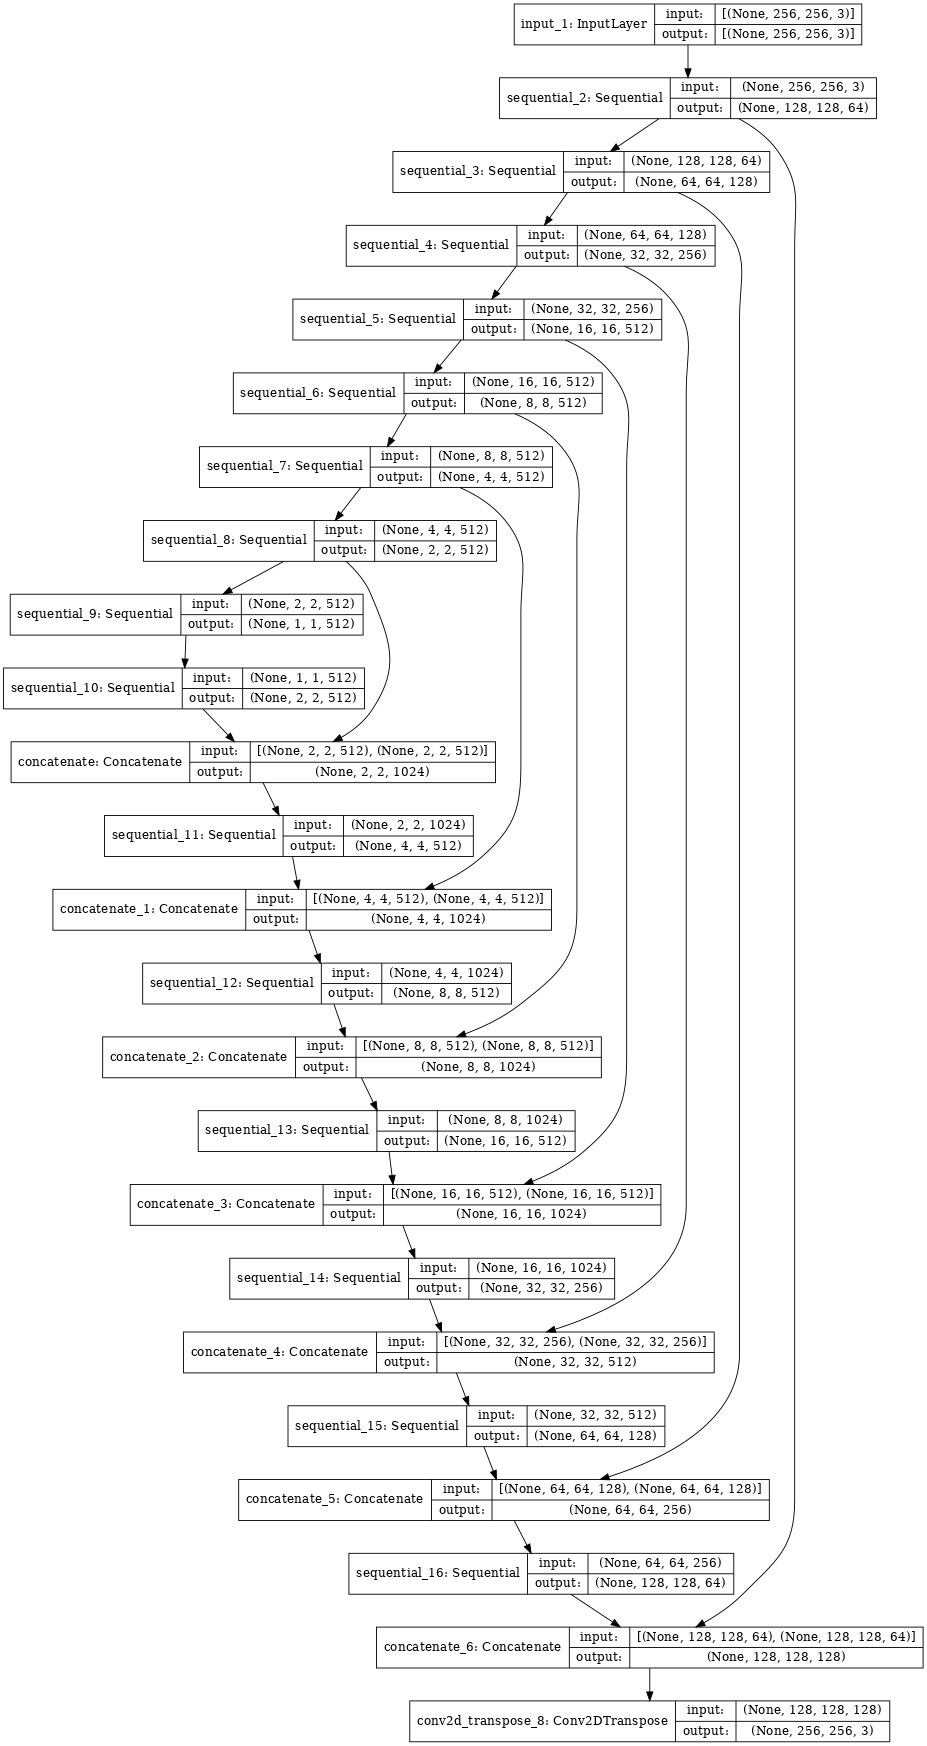

In [28]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

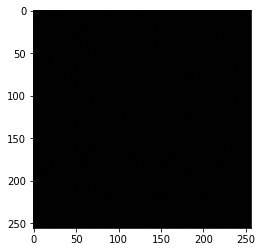

In [29]:
import random 
import numpy as np


ex_in = np.random.rand(1, 256, 256, 3)
# gen_output = generator(inp[tf.newaxis, ...], training=False)
gen_output = generator(ex_in, training=False)
plt.imshow(gen_output[0, ...])

In [30]:

LAMBDA = 100

In [31]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [32]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [33]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

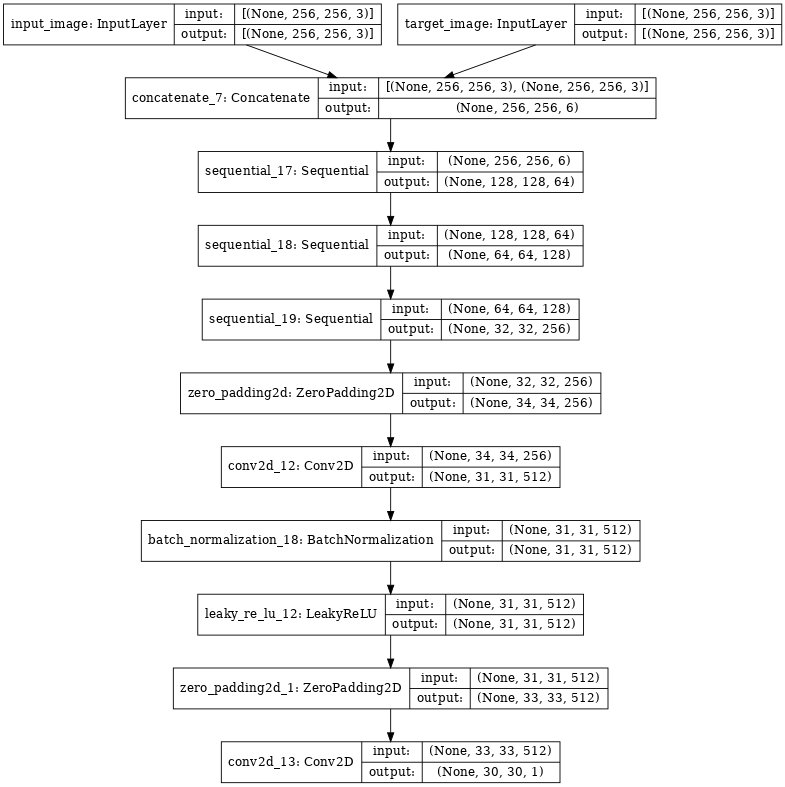

In [34]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

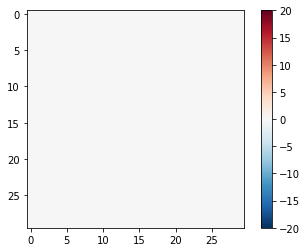

In [35]:
# disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
disc_out = discriminator([ex_in, gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [36]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [37]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [38]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [39]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

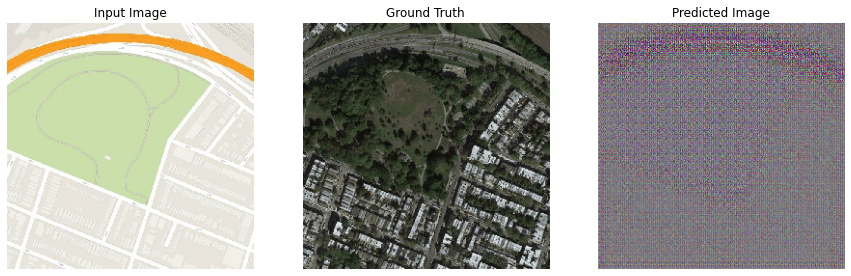

In [40]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

In [41]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [42]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [43]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

In [44]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

Time taken for 1000 steps: 754.78 sec



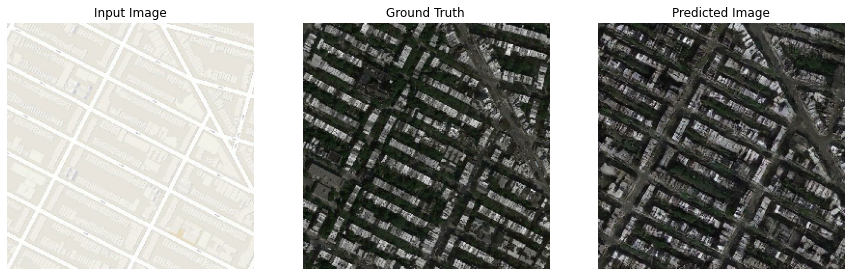

Step: 39k
..

2021-10-12 21:28:37.875373: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 1001 of 2000
2021-10-12 21:28:38.738555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


....

2021-10-12 21:29:04.046941: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 1055 of 2000
2021-10-12 21:29:04.464037: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


...

2021-10-12 21:29:29.776717: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 965 of 2000
2021-10-12 21:29:31.112148: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


....

2021-10-12 21:29:56.383533: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 965 of 2000
2021-10-12 21:29:58.000723: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


...

2021-10-12 21:30:23.264858: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 1039 of 2000
2021-10-12 21:30:23.846159: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


....

2021-10-12 21:30:49.153471: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 1014 of 2000
2021-10-12 21:30:49.906853: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


...

2021-10-12 21:31:15.187782: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 1035 of 2000
2021-10-12 21:31:15.775096: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


....

2021-10-12 21:31:41.064381: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 961 of 2000
2021-10-12 21:31:43.032153: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


...

2021-10-12 21:32:08.290194: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 955 of 2000
2021-10-12 21:32:09.578876: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


....

2021-10-12 21:32:34.853039: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 1000 of 2000
2021-10-12 21:32:35.857810: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


...

2021-10-12 21:33:01.152927: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 1000 of 2000
2021-10-12 21:33:02.034509: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


....

2021-10-12 21:33:27.328624: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 1033 of 2000
2021-10-12 21:33:28.128504: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


...

2021-10-12 21:33:53.443779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 985 of 2000
2021-10-12 21:33:54.673732: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


....

2021-10-12 21:34:19.978943: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 938 of 2000
2021-10-12 21:34:21.569083: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


...

2021-10-12 21:34:46.865977: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 1030 of 2000
2021-10-12 21:34:47.468156: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


....

2021-10-12 21:35:12.779730: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 987 of 2000
2021-10-12 21:35:14.281296: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


...

2021-10-12 21:35:39.557130: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 1030 of 2000
2021-10-12 21:35:40.208162: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


....

2021-10-12 21:36:05.513369: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 999 of 2000
2021-10-12 21:36:06.569418: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


...

2021-10-12 21:36:31.839031: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 962 of 2000
2021-10-12 21:36:33.060425: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


....

2021-10-12 21:36:58.344659: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 1024 of 2000
2021-10-12 21:36:59.177377: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


...

2021-10-12 21:37:24.509107: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 1019 of 2000
2021-10-12 21:37:25.203927: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


....

2021-10-12 21:37:50.495849: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 1018 of 2000
2021-10-12 21:37:51.197614: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


...

2021-10-12 21:38:16.498695: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 957 of 2000
2021-10-12 21:38:18.060760: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


....

2021-10-12 21:38:43.318385: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 947 of 2000
2021-10-12 21:38:45.124800: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


...

2021-10-12 21:39:10.376484: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 1013 of 2000
2021-10-12 21:39:11.155666: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


....

2021-10-12 21:39:36.468989: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 1011 of 2000
2021-10-12 21:39:37.258144: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


...

2021-10-12 21:40:02.544414: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 1014 of 2000
2021-10-12 21:40:03.301099: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


....

2021-10-12 21:40:28.588019: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 977 of 2000
2021-10-12 21:40:30.424308: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


...

In [45]:
fit(train_dataset, test_dataset, steps=40000)

In [46]:
generator.save("Generator")

2021-10-12 21:40:49.219216: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [47]:
discriminator.save("Discriminator")

In [48]:
display.IFrame(
    src="https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw",
    width="100%",
    height="1000px")

In [49]:
!ls {checkpoint_dir}

checkpoint		    ckpt-5.data-00000-of-00001
ckpt-1.data-00000-of-00001  ckpt-5.index
ckpt-1.index		    ckpt-6.data-00000-of-00001
ckpt-2.data-00000-of-00001  ckpt-6.index
ckpt-2.index		    ckpt-7.data-00000-of-00001
ckpt-3.data-00000-of-00001  ckpt-7.index
ckpt-3.index		    ckpt-8.data-00000-of-00001
ckpt-4.data-00000-of-00001  ckpt-8.index
ckpt-4.index


In [50]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

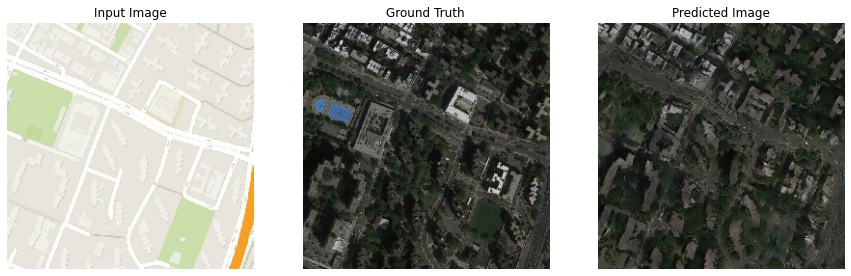

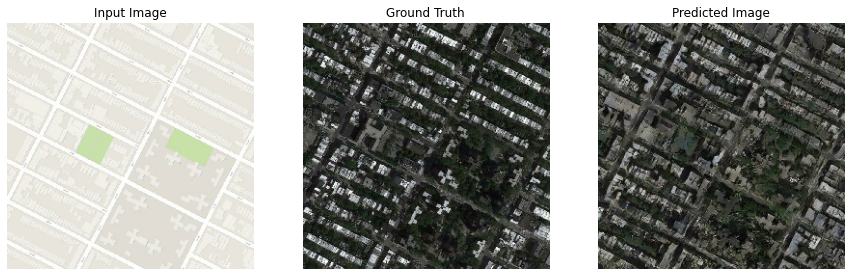

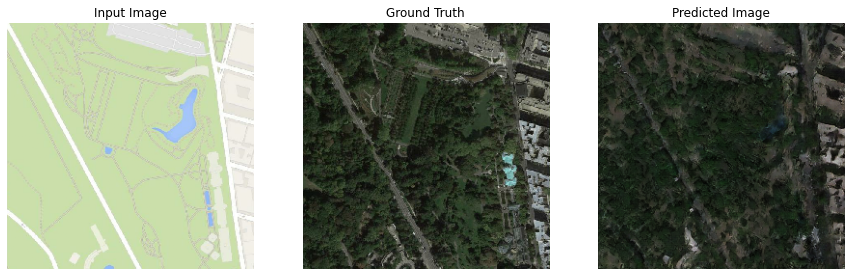

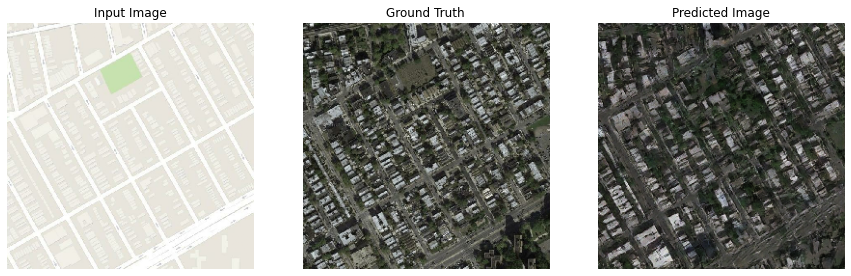

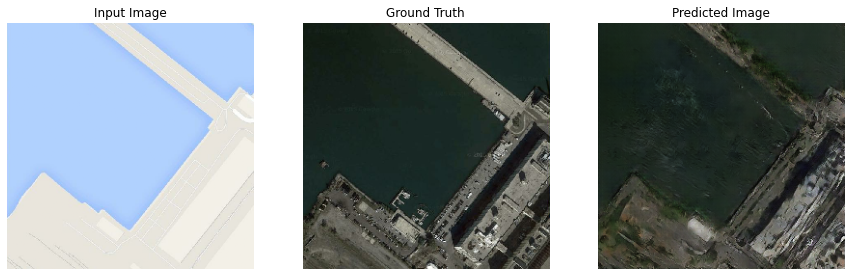

In [51]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)

In [52]:
image_path= "../input/map-without-label-image/snazzy-image.png"

In [53]:
# ii, ri = load("/content/maps/val/1.jpg")

In [54]:
prediction_image = tf.io.read_file(image_path)
prediction_image = tf.image.decode_image(prediction_image, channels=3)
prediction_image = tf.image.resize(prediction_image, (256, 256))
prediction_image = tf.expand_dims(prediction_image, axis=0)
prediction_image = tf.cast(prediction_image, dtype=tf.float32)
prediction_image = (prediction_image / 127.5) -1
prediction_image.shape

TensorShape([1, 256, 256, 3])

In [55]:
generated_image = generator.predict(prediction_image)

In [56]:
generated_image = tf.cast(generated_image, dtype = tf.float32)

In [57]:
generated_image = tf.squeeze(generated_image, axis=0)

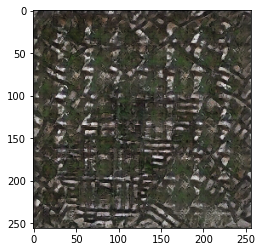

In [58]:
plt.imshow((generated_image+1)/2.0);

In [59]:
# prediction_image = tf.image.resize(ii, (256, 256))
# prediction_image = tf.expand_dims(prediction_image, axis=0)
# prediction_image = tf.cast(prediction_image, dtype=tf.float32)
# prediction_image = (prediction_image / 127.5) -1
# prediction_image.shape

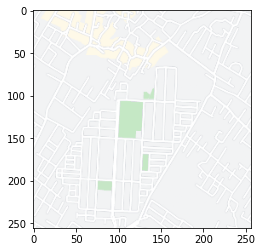

In [60]:
plt.imshow(tf.squeeze(prediction_image, axis=0)*0.5 +0.5)

In [61]:
!zip -r Discriminator.zip ./Discriminator

  adding: Discriminator/ (stored 0%)
  adding: Discriminator/variables/ (stored 0%)
  adding: Discriminator/variables/variables.index (deflated 58%)
  adding: Discriminator/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: Discriminator/assets/ (stored 0%)
  adding: Discriminator/saved_model.pb (deflated 91%)


In [62]:
!zip -r Generator.zip ./Generator

  adding: Generator/ (stored 0%)
  adding: Generator/variables/ (stored 0%)
  adding: Generator/variables/variables.index (deflated 73%)
  adding: Generator/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: Generator/assets/ (stored 0%)
  adding: Generator/saved_model.pb (deflated 92%)


In [63]:
!ls

Discriminator	   Generator	  __notebook__.ipynb  model.png
Discriminator.zip  Generator.zip  logs		      training_checkpoints
